In [16]:
!pip install \
    tensorflow==2.8.0 \
    tensorflow-hub==0.12.0 \
    matplotlib==3.2.2

In [22]:
# https://drive.google.com/file/d/1nY7mB9gYs9Jl88BOYCQjkMiCVMZTiQtg/view?usp=sharing
# https://drive.google.com/file/d/1M1eDdinWr-aPT28cyOo01LlMFUnsBbRQ/view?usp=sharing
# https://drive.google.com/file/d/1QI4SzMWctxLopTC5pSz1SISr98rnGYuO/view?usp=sharing
!rm sample.jpg
!wget "https://drive.google.com/uc?export=download&id=1M1eDdinWr-aPT28cyOo01LlMFUnsBbRQ" -O sample.jpg

--2022-05-05 14:40:06--  https://drive.google.com/uc?export=download&id=1M1eDdinWr-aPT28cyOo01LlMFUnsBbRQ
Resolving drive.google.com (drive.google.com)... 74.125.140.113, 74.125.140.139, 74.125.140.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.140.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8vbmn2obmkllip9mo84omvl3b1qbfr3b/1651761600000/06980775801156495326/*/1M1eDdinWr-aPT28cyOo01LlMFUnsBbRQ?e=download [following]
--2022-05-05 14:40:07--  https://doc-00-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8vbmn2obmkllip9mo84omvl3b1qbfr3b/1651761600000/06980775801156495326/*/1M1eDdinWr-aPT28cyOo01LlMFUnsBbRQ?e=download
Resolving doc-00-40-docs.googleusercontent.com (doc-00-40-docs.googleusercontent.com)... 142.251.5.132, 2a00:1450:400c:c1b::84
Connecting to doc-00-40-docs.googleusercontent.com (doc-00-40-docs.

In [23]:
!ls /content/sample.jpg

/content/sample.jpg


In [24]:
import cv2
image = cv2.imread('/content/sample.jpg')

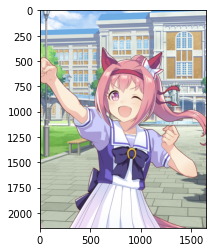

In [25]:
import matplotlib.pyplot as plt

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

In [26]:
import tensorflow_hub as hub

module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])
model = module.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [27]:
import tensorflow as tf

# 画像読み込み
image = cv2.imread('sample.jpg')

# リサイズ
resize_image = cv2.resize(image, (256, 256))

# 正規化
resize_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB) / 255.0

# 形状変更
resize_image = resize_image.transpose(2, 0, 1)
resize_image = resize_image.reshape(1, 3, 256, 256)

# tensor形式へ変換
tensor = tf.convert_to_tensor(resize_image, dtype=tf.float32)

In [28]:
result = model(tensor)

In [29]:
import numpy as np

predict_result = result['default'].numpy()
predict_result = np.squeeze(predict_result)
print(predict_result.shape)

(256, 256)


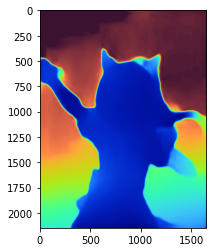

In [30]:
import matplotlib.pyplot as plt

# オリジナル画像のサイズにリサイズ
predict_result = cv2.resize(predict_result, (image.shape[1], image.shape[0]))

# 最大値が255になるよう変換
depth_max = predict_result.max()
data = ((predict_result / depth_max) * 255).astype(np.uint8)

# カラーマップ画像へ変換
color_map = cv2.applyColorMap(data, cv2.COLORMAP_TURBO)

# 表示
plt.imshow(color_map)

In [32]:
def median_filter(src, ksize):
    # 畳み込み演算をしない領域の幅
    # width of skip
    d = int((ksize-1)/2)
    h, w = src.shape[0], src.shape[1]

    # ndarray of destination
    # 出力画像用の配列（要素は入力画像と同じ）
    dst = src.copy()

    for y in range(d, h - d):
        for x in range(d, w - d):
            # 近傍にある画素値の中央値を出力画像の画素値に設定
            dst[y][x] = np.median(src[y-d:y+d+1, x-d:x+d+1])

    return dst

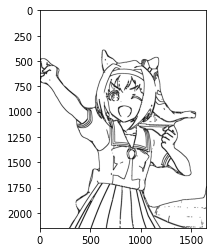

In [34]:
# 深度情報をフィルタ（data: 画像）
# 100以上をフィルタ
mask = data > 150
# maskを二値化
mask = mask.astype(np.uint8) * 255

# imageとmaskの合成
result = cv2.bitwise_and(image, image, mask=mask)

# bgr2rgb
result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
result = median_filter(result, ksize=5)

# エッジ検出
edges2 = cv2.Canny(result, 199, 200)
kernel = np.ones((5,5),np.uint8)
edges2 = cv2.morphologyEx(edges2, cv2.MORPH_CLOSE, kernel)
edges2 = cv2.morphologyEx(edges2, cv2.MORPH_GRADIENT, kernel)
# 反転
edges2 = cv2.bitwise_not(edges2)
# 0か255に分類
edges2 = edges2.astype(np.uint8) * 255 * 255
# gray2bgr
edges2 = cv2.cvtColor(edges2, cv2.COLOR_GRAY2BGR)

# 2値
# edges2 = cv2.threshold(edges2, 200, 255, cv2.THRESH_BINARY, dst=edges2)
# edges2 = edges2.astype(np.uint8) * 255

# 表示
plt.imshow(edges2)
# 保存
# cv2.imwrite('edges.jpg', edges2)
from google.colab import files

# files.download('edges.jpg')

In [35]:
export_png = np.zeros((data.shape[0], data.shape[1], 3))
export_png[:,:,0] = data/255
export_png[:,:,1] = data/255
export_png[:,:,2] = data/255

plt.imsave("/content/depth_result.png",export_png)
files.download('depth_result.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>